## Marriage Trends in India

In [115]:
import pandas as pd
import numpy as np
from numpy.ma.core import arange
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('marriage_data_india.csv')
display(data.head())

,ID,Marriage_Type,Age_at_Marriage,Gender,Education_Level,Caste_Match,Religion,Parental_Approval,Urban_Rural,Dowry_Exchanged,Marital_Satisfaction,Divorce_Status,Children_Count,Income_Level,Years_Since_Marriage,Spouse_Working,Inter-Caste,Inter-Religion
0,1,Love,23,Male,Graduate,Different,Hindu,No,Urban,No,Medium,Yes,5,Middle,34,No,No,No
1,2,Love,28,Female,School,Same,Hindu,Yes,Rural,Yes,Low,No,3,Middle,42,No,No,Yes
2,3,Arranged,39,Male,Postgraduate,Same,Muslim,Yes,Rural,No,Medium,No,0,High,25,No,No,No
3,4,Arranged,26,Female,School,Different,Hindu,Yes,Urban,Yes,Low,No,0,High,12,No,Yes,No
4,5,Love,32,Female,Graduate,Same,Hindu,Partial,Rural,Yes,Medium,No,1,Middle,41,No,No,Yes


In [116]:
display(data.isna().sum())

ID                      0
Marriage_Type           0
Age_at_Marriage         0
Gender                  0
Education_Level         0
Caste_Match             0
Religion                0
Parental_Approval       0
Urban_Rural             0
Dowry_Exchanged         0
Marital_Satisfaction    0
Divorce_Status          0
Children_Count          0
Income_Level            0
Years_Since_Marriage    0
Spouse_Working          0
Inter-Caste             0
Inter-Religion          0
dtype: int64

In [117]:
# List of categorical columns
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
display("categorical_cols: ", cat_cols)

# List of numerical columns
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
display("numerical_cols: ", num_cols)

'categorical_cols: '

['Marriage_Type',
 'Gender',
 'Education_Level',
 'Caste_Match',
 'Religion',
 'Parental_Approval',
 'Urban_Rural',
 'Dowry_Exchanged',
 'Marital_Satisfaction',
 'Divorce_Status',
 'Income_Level',
 'Spouse_Working',
 'Inter-Caste',
 'Inter-Religion']

'numerical_cols: '

['ID', 'Age_at_Marriage', 'Children_Count', 'Years_Since_Marriage']

C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col,data=data,palette='magma')
C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Categories')


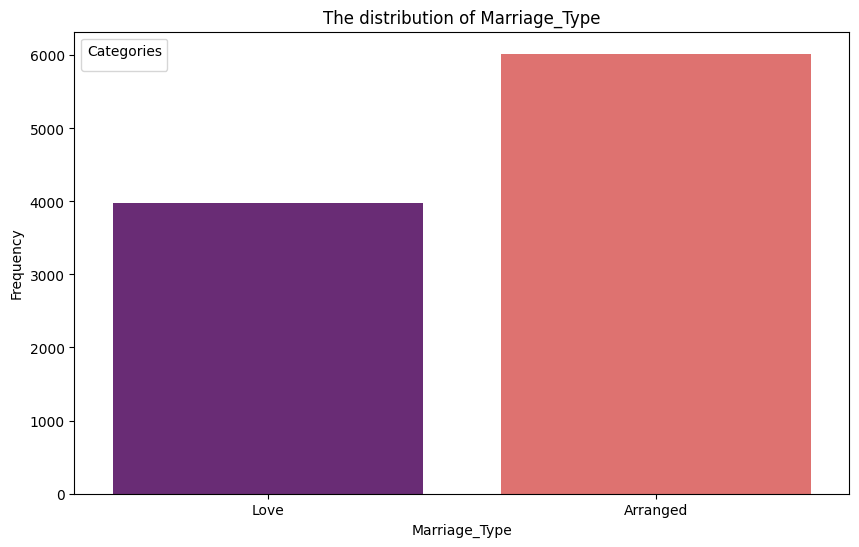

C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col,data=data,palette='magma')
C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Categories')


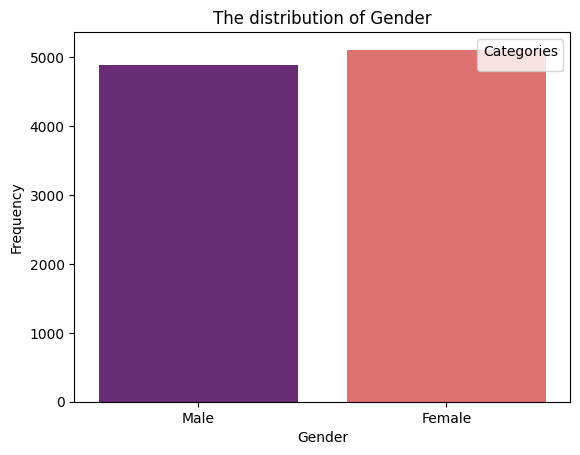

C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col,data=data,palette='magma')
C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Categories')


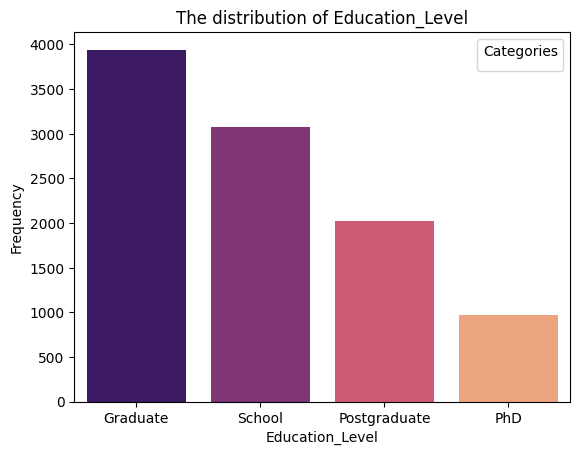

C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col,data=data,palette='magma')
C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Categories')


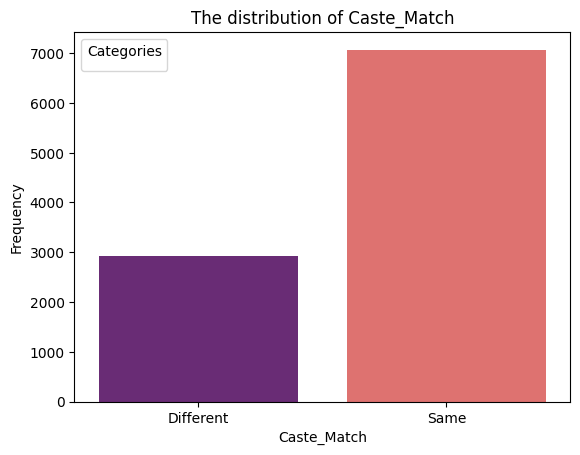

C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col,data=data,palette='magma')
C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Categories')


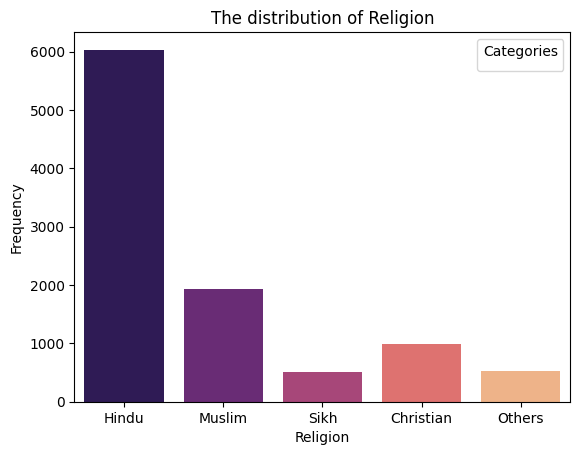

C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col,data=data,palette='magma')
C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Categories')


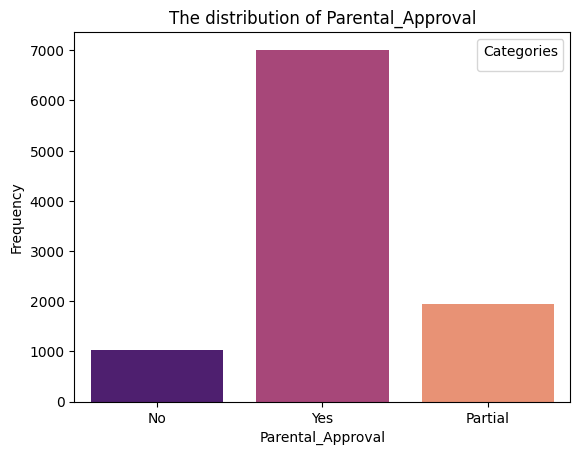

C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col,data=data,palette='magma')
C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Categories')


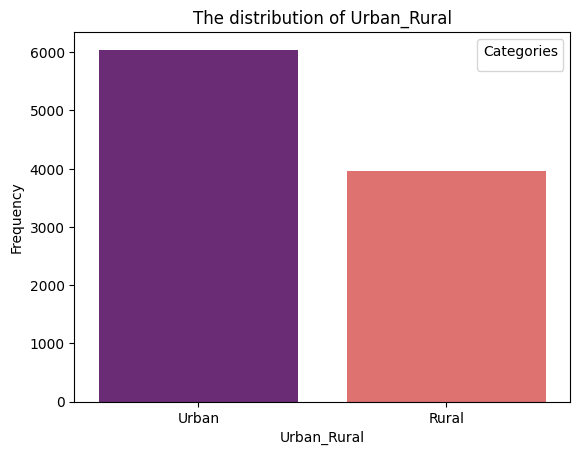

C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col,data=data,palette='magma')
C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Categories')


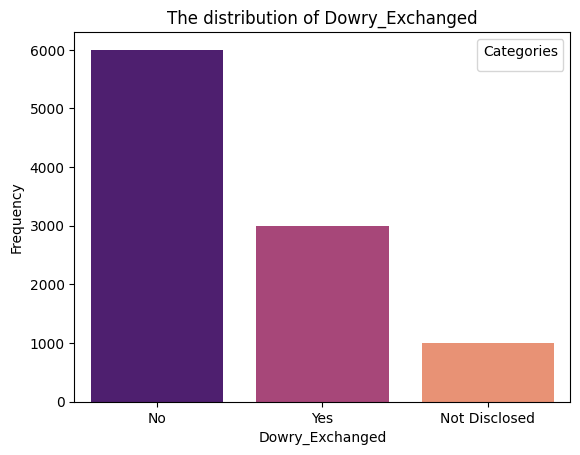

C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col,data=data,palette='magma')
C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Categories')


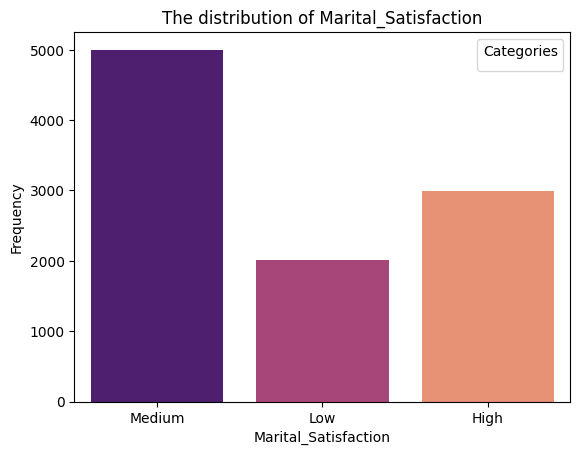

C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col,data=data,palette='magma')
C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Categories')


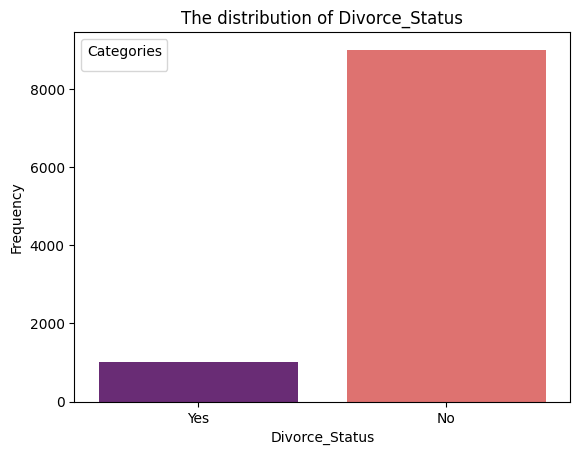

C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col,data=data,palette='magma')
C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Categories')


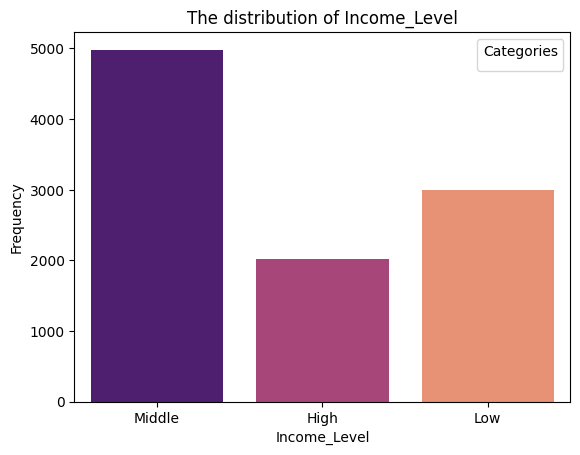

C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col,data=data,palette='magma')
C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Categories')


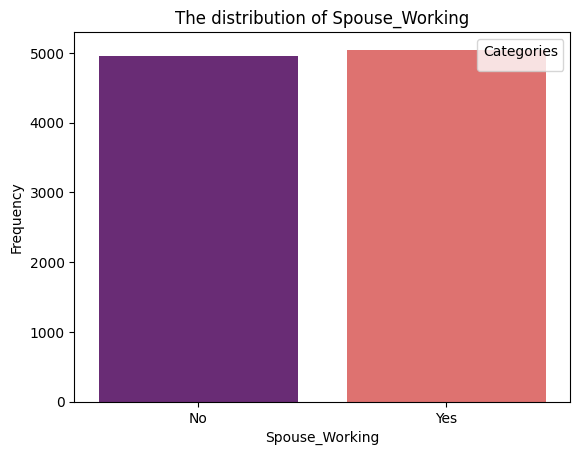

C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col,data=data,palette='magma')
C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Categories')


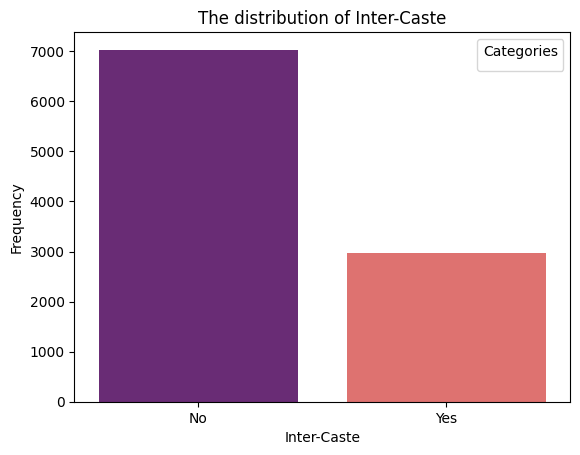

C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col,data=data,palette='magma')
C:\Users\yelisev\AppData\Local\Temp\ipykernel_30392\1124581316.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Categories')


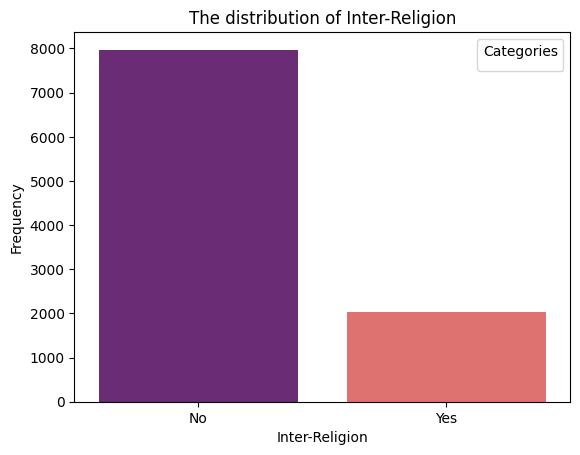

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6)) 
for col in cat_cols:
    sns.countplot(x=col,data=data,palette='magma')
    plt.ylabel('Frequency')
    plt.title(f'The distribution of {col}')
    plt.legend(title='Categories')
    plt.show()

In [118]:
X = data.drop(columns=['ID','Divorce_Status'])
y = data['Divorce_Status']

X['Inter_Caste'] = X['Inter-Caste']
X['Inter_Religion'] = X['Inter-Religion']
X.drop(columns=['Inter-Caste','Inter-Religion'], inplace=True)

In [119]:
categorical_cols = [
    'Marriage_Type', 
    'Gender', 
    'Education_Level', 
    'Caste_Match', 
    'Religion', 
    'Parental_Approval', 
    'Urban_Rural', 
    'Dowry_Exchanged',
    'Marital_Satisfaction', 
    'Income_Level',
    'Spouse_Working', 
    'Inter_Caste', 
    'Inter_Religion']

X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
display(X.head())

,Age_at_Marriage,Children_Count,Years_Since_Marriage,Marriage_Type_Love,Gender_Male,Education_Level_PhD,Education_Level_Postgraduate,Education_Level_School,Caste_Match_Same,Religion_Hindu,...,Urban_Rural_Urban,Dowry_Exchanged_Not Disclosed,Dowry_Exchanged_Yes,Marital_Satisfaction_Low,Marital_Satisfaction_Medium,Income_Level_Low,Income_Level_Middle,Spouse_Working_Yes,Inter_Caste_Yes,Inter_Religion_Yes
0,23,5,34,True,True,False,False,False,False,True,...,True,False,False,False,True,False,True,False,False,False
1,28,3,42,True,False,False,False,True,True,True,...,False,False,True,True,False,False,True,False,False,True
2,39,0,25,False,True,False,True,False,True,False,...,False,False,False,False,True,False,False,False,False,False
3,26,0,12,False,False,False,False,True,False,True,...,True,False,True,True,False,False,False,False,True,False
4,32,1,41,True,False,False,False,False,True,True,...,False,False,True,False,True,False,True,False,False,True


In [120]:
le = LabelEncoder()
y = le.fit_transform(y)

In [121]:
from imblearn.over_sampling import SMOTE
smote_obj = SMOTE()
X_new, y_new = smote_obj.fit_resample(X, y)

In [122]:
import statsmodels.api as sm

def backwardElimination(x, y, sl):
    numVars = len(x[0])
    indices = list(range(numVars))
    for i in range(0, numVars):
        obj_OLS = sm.OLS(y, x).fit()
        maxVar = max(obj_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, len(indices)):
                if (obj_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    indices.pop(j)
                    break
    display(obj_OLS.summary())
    return x, indices      

SL = 0.05
X_backe = np.append(arr=np.ones((len(X_new),1)), values=X_new, axis=1)
X_backe = X_backe.astype('float64')
X_sig = X_backe
X_Modeled, indices = backwardElimination(X_sig, y_new, SL)
display(X_Modeled)
display(indices)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     692.4
Date:                Sun, 20 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:36:12   Log-Likelihood:                -7170.8
No. Observations:               17998   AIC:                         1.439e+04
Df Residuals:                   17973   BIC:                         1.459e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3282      0.015     86.216      0.000       1.298       1.358
x1             0.0010      0.000      2.339      0.019       0.000       0.002
x2            -0.0144      0.002     -8.825      0.000      -0.018      -0.011
x3            -0.0880      0.006    -14.835      0.000      -0.100      -0.076
x4            -0.1088      0.006    -19.458      0.000      -0.120      -0.098
x5            -0.2395      0.012    -20.136      0.000      -0.263      -0.216
x6            -0.2166      0.008    -25.881      0.000      -0.233      -0.200
x7            -0.1783      0.007    -25.833      0.000      -0.192      -0.165
x8            -0.0646      0.006    -11.436      0.000      -0.076      -0.054
x9            -0.2035      0.007    -30.889      0.000      -0.216      -0.191
x10           -0.2888      0.009    -30.624      0.000      -0.307      -0.270
x11           -0.3447      0.016    -21.044      0.000      -0.377      -0.313
x12           -0.3629      0.017    -21.717      0.000      -0.396      -0.330
x13           -0.2855      0.010    -29.436      0.000      -0.305      -0.267
x14           -0.1638      0.007    -24.397      0.000      -0.177      -0.151
x15           -0.0585      0.005    -10.739      0.000      -0.069      -0.048
x16           -0.1852      0.012    -16.023      0.000      -0.208      -0.163
x17           -0.1165      0.007    -17.507      0.000      -0.130      -0.103
x18           -0.2062      0.009    -23.776      0.000      -0.223      -0.189
x19           -0.1379      0.006    -23.326      0.000      -0.150      -0.126
x20           -0.1705      0.008    -22.697      0.000      -0.185      -0.156
x21           -0.1215      0.006    -19.243      0.000      -0.134      -0.109
x22           -0.0930      0.006    -16.623      0.000      -0.104      -0.082
x23           -0.1275      0.007    -18.805      0.000      -0.141      -0.114
x24           -0.1160      0.008    -14.678      0.000      -0.131      -0.101
==============================================================================
Omnibus:                      283.675   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              296.904
Skew:                           0.314   Prob(JB):                     3.37e-65
Kurtosis:                       3.050   Cond. No.                         200.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([[ 1., 23.,  5., ...,  0.,  0.,  0.],
       [ 1., 28.,  3., ...,  0.,  0.,  1.],
       [ 1., 39.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 1., 37.,  1., ...,  1.,  0.,  0.],
       [ 1., 37.,  1., ...,  1.,  0.,  0.],
       [ 1., 31.,  3., ...,  0.,  0.,  0.]])

[0,
 1,
 2,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25]

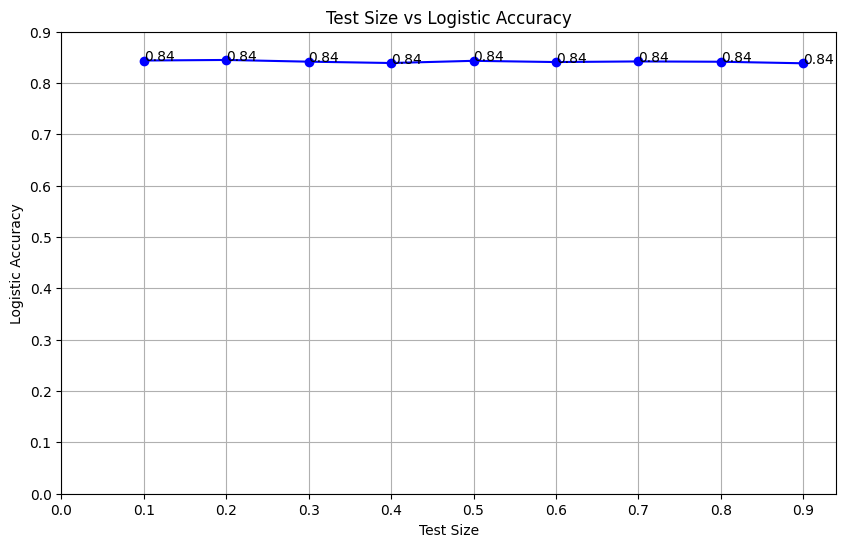

In [ ]:
# #Testing different test sizes vs. accuracy for Logistic Regression
# from sklearn.linear_model import LogisticRegression

# accuracy_scores = []
# for i in arange(0.1, 1.0, 0.1):
#     X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_new, y_new, test_size=i, random_state=42, stratify=y_new)

#     scaler_cols = ['Age_at_Marriage', 'Children_Count', 'Years_Since_Marriage']
#     scaler = StandardScaler()

#     X_train_smote[scaler_cols] = scaler.fit_transform(X_train_smote[scaler_cols])
#     X_test_smote[scaler_cols] = scaler.transform(X_test_smote[scaler_cols])   

#     classifierObj = LogisticRegression()
#     classifierObj.fit(X_train_smote, y_train_smote)

#     #Making predictions on the Test Set
#     y_pred = classifierObj.predict(X_test_smote)
#     #Print Model Accuracy
#     accuracy_scores.append(classifierObj.score(X_test_smote,y_test_smote))
 
# #graph i vs accuracy
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# # show values on the line
# for i, txt in enumerate(accuracy_scores):
#     plt.annotate(round(txt, 2), (arange(0.1, 1.0, 0.1)[i], accuracy_scores[i]), fontsize=10)
# plt.plot(arange(0.1, 1.0, 0.1), accuracy_scores, marker='o', color='blue', linestyle='-')
# plt.title('Test Size vs Logistic Accuracy')
# plt.xlabel('Test Size')
# plt.ylabel('Logistic Accuracy')
# plt.xticks(arange(0, 1, .1))
# plt.yticks(arange(0, 1, .1))
# plt.grid()

In [125]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_new, y_new, test_size=.5, random_state=42, stratify=y_new)

In [126]:
scaler_cols = ['Age_at_Marriage', 'Children_Count', 'Years_Since_Marriage']
scaler = StandardScaler()

X_train_smote[scaler_cols] = scaler.fit_transform(X_train_smote[scaler_cols])
X_test_smote[scaler_cols] = scaler.transform(X_test_smote[scaler_cols])

display(X_train_smote.head())
display(X_test_smote.head())

,Age_at_Marriage,Children_Count,Years_Since_Marriage,Marriage_Type_Love,Gender_Male,Education_Level_PhD,Education_Level_Postgraduate,Education_Level_School,Caste_Match_Same,Religion_Hindu,...,Urban_Rural_Urban,Dowry_Exchanged_Not Disclosed,Dowry_Exchanged_Yes,Marital_Satisfaction_Low,Marital_Satisfaction_Medium,Income_Level_Low,Income_Level_Middle,Spouse_Working_Yes,Inter_Caste_Yes,Inter_Religion_Yes
12626,1.516841,-0.816638,-1.010368,True,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
1655,0.707412,-1.417040,-1.438648,True,True,False,True,False,True,False,...,False,False,True,True,False,False,False,True,False,False
10046,1.354955,0.984569,-1.010368,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
11820,0.059868,-1.417040,1.273789,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1477,-0.749561,0.984569,-1.224508,False,True,False,False,True,True,False,...,True,False,False,True,False,False,True,True,False,False


,Age_at_Marriage,Children_Count,Years_Since_Marriage,Marriage_Type_Love,Gender_Male,Education_Level_PhD,Education_Level_Postgraduate,Education_Level_School,Caste_Match_Same,Religion_Hindu,...,Urban_Rural_Urban,Dowry_Exchanged_Not Disclosed,Dowry_Exchanged_Yes,Marital_Satisfaction_Low,Marital_Satisfaction_Medium,Income_Level_Low,Income_Level_Middle,Spouse_Working_Yes,Inter_Caste_Yes,Inter_Religion_Yes
10535,-0.425789,-0.816638,0.203090,True,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
9021,0.707412,-0.216235,-1.153128,True,True,False,False,True,True,False,...,True,False,True,True,False,True,False,False,True,False
3257,0.383640,0.384167,-0.867608,False,False,False,False,True,False,False,...,False,False,False,True,False,False,True,True,True,False
10240,-0.263903,-0.816638,-0.225189,True,True,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
14594,1.678727,-1.417040,-1.510027,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False


In [127]:
#Applying PCA
from sklearn.decomposition import PCA

#Standardizing the data before PCA
pcaObj = PCA(n_components=.9)
X_train_pca = pcaObj.fit_transform(X_train_smote)
X_test_pca = pcaObj.transform(X_test_smote)

In [128]:
display(X_train_smote)

,Age_at_Marriage,Children_Count,Years_Since_Marriage,Marriage_Type_Love,Gender_Male,Education_Level_PhD,Education_Level_Postgraduate,Education_Level_School,Caste_Match_Same,Religion_Hindu,...,Urban_Rural_Urban,Dowry_Exchanged_Not Disclosed,Dowry_Exchanged_Yes,Marital_Satisfaction_Low,Marital_Satisfaction_Medium,Income_Level_Low,Income_Level_Middle,Spouse_Working_Yes,Inter_Caste_Yes,Inter_Religion_Yes
12626,1.516841,-0.816638,-1.010368,True,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
1655,0.707412,-1.417040,-1.438648,True,True,False,True,False,True,False,...,False,False,True,True,False,False,False,True,False,False
10046,1.354955,0.984569,-1.010368,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
11820,0.059868,-1.417040,1.273789,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1477,-0.749561,0.984569,-1.224508,False,True,False,False,True,True,False,...,True,False,False,True,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14532,1.031183,-0.216235,0.559990,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,True
4447,0.869298,1.584971,-1.081748,False,False,False,False,True,True,True,...,True,False,False,True,False,True,False,True,True,False
11139,0.059868,-1.417040,-0.296569,False,False,False,False,False,True,True,...,True,False,False,True,False,False,False,True,False,False
13505,-1.073332,-0.216235,1.702069,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False


In [129]:
#Fitting Logistic Regression to Training Set
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

classifierObj = LogisticRegression()
classifierObj.fit(X_train_pca, y_train_smote)
#Making predictions on the Test Set
y_pred = classifierObj.predict(X_test_pca)
print(y_pred)
#Predicting probabilities
y_pred_prob = classifierObj.predict_proba(X_test_pca)
#Print Model Accuracy
print(classifierObj.score(X_test_pca, y_test_smote))

[1 0 0 ... 0 0 1]
0.8100900100011112


In [ ]:
# #Applying LDA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# max_components = min(X_train_smote.shape[1], len(np.unique(y_train_smote)) - 1)
# ldaObj = LDA(n_components=max_components)
# X_train_lda = ldaObj.fit_transform(X_train_smote,y_train_smote)
# X_test = ldaObj.transform(X_test_smote)

# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.scatter(X_train_lda, np.zeros_like(X_train_lda), c=y_train_smote, cmap='viridis', edgecolor='k')
# plt.title("LDA Transformed Training Data")
# plt.xlabel("LDA Component")
# plt.ylabel("Zero Line")
# plt.colorbar(label='Class Label')
# plt.show()


In [ ]:
# from sklearn.decomposition import KernelPCA

# # Performing Kernel PCA
# kernel_pca = KernelPCA(n_components=25, kernel='rbf')
# X_train_kernel_pca = kernel_pca.fit_transform(X_train_smote)
# X_test_kernel_pca = kernel_pca.transform(X_test_smote)

# # Scatter plot of Kernel PCA transformed data
# plt.figure(figsize=(10, 6))
# plt.scatter(X_train_kernel_pca[:, 3], X_train_kernel_pca[:, 4], c=y_train_smote, cmap='viridis', edgecolor='k')
# plt.title("Kernel PCA Transformed Training Data")
# plt.xlabel("Kernel PCA Component 1")
# plt.ylabel("Kernel PCA Component 2")
# plt.colorbar(label='Class Label')
# plt.show()


In [130]:
from sklearn.metrics import classification_report

def modelclassificationreport(classifier, classifierName):
    classifier.fit(X_train_pca, y_train_smote)
    y_pred = classifier.predict(X_test_pca)
    print("Classification Report for Classifier: {}, className: {}".format(classifier, classifierName))
    report = classification_report(y_test_smote, y_pred)
    print(report)

In [131]:
#logistic regression
from sklearn.linear_model import LogisticRegression

logistic_classifier = LogisticRegression(random_state=0)
modelclassificationreport(logistic_classifier, "Logistic Regression")

Classification Report for Classifier: LogisticRegression(random_state=0), className: Logistic Regression
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      4500
           1       0.81      0.81      0.81      4499

    accuracy                           0.81      8999
   macro avg       0.81      0.81      0.81      8999
weighted avg       0.81      0.81      0.81      8999



In [132]:
from sklearn.ensemble import RandomForestClassifier
modelclassificationreport(RandomForestClassifier(), "RandomForestClassifier")

Classification Report for Classifier: RandomForestClassifier(), className: RandomForestClassifier
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      4500
           1       0.90      0.86      0.88      4499

    accuracy                           0.88      8999
   macro avg       0.88      0.88      0.88      8999
weighted avg       0.88      0.88      0.88      8999



In [133]:
from sklearn.svm import SVC
modelclassificationreport(SVC(kernel='rbf'), "RBF SVM")

Classification Report for Classifier: SVC(), className: RBF SVM
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      4500
           1       0.86      0.84      0.85      4499

    accuracy                           0.85      8999
   macro avg       0.85      0.85      0.85      8999
weighted avg       0.85      0.85      0.85      8999



In [134]:
from sklearn.svm import SVC
modelclassificationreport(SVC(kernel='poly'), "SVM with poly")

Classification Report for Classifier: SVC(kernel='poly'), className: SVM with poly
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      4500
           1       0.80      0.86      0.83      4499

    accuracy                           0.82      8999
   macro avg       0.82      0.82      0.82      8999
weighted avg       0.82      0.82      0.82      8999



In [135]:
from sklearn.tree import DecisionTreeClassifier
modelclassificationreport(DecisionTreeClassifier(criterion="entropy"), "DecisionTreeClassifier")

Classification Report for Classifier: DecisionTreeClassifier(criterion='entropy'), className: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.84      0.77      0.80      4500
           1       0.79      0.86      0.82      4499

    accuracy                           0.81      8999
   macro avg       0.81      0.81      0.81      8999
weighted avg       0.81      0.81      0.81      8999



In [136]:
from sklearn.naive_bayes import GaussianNB
modelclassificationreport(GaussianNB(), "GaussianNB")

Classification Report for Classifier: GaussianNB(), className: GaussianNB
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      4500
           1       0.80      0.78      0.79      4499

    accuracy                           0.79      8999
   macro avg       0.79      0.79      0.79      8999
weighted avg       0.79      0.79      0.79      8999



In [137]:
# Ada Boosting
from sklearn.ensemble import AdaBoostClassifier
modelclassificationreport(AdaBoostClassifier(), "AdaBoostClassifier")

Classification Report for Classifier: AdaBoostClassifier(), className: AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      4500
           1       0.80      0.81      0.80      4499

    accuracy                           0.80      8999
   macro avg       0.80      0.80      0.80      8999
weighted avg       0.80      0.80      0.80      8999



In [138]:
#GRadient Boosting
from sklearn.ensemble import GradientBoostingClassifier
modelclassificationreport(GradientBoostingClassifier(), "GradientBoostingClassifier")

Classification Report for Classifier: GradientBoostingClassifier(), className: GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      4500
           1       0.85      0.82      0.83      4499

    accuracy                           0.84      8999
   macro avg       0.84      0.84      0.84      8999
weighted avg       0.84      0.84      0.84      8999



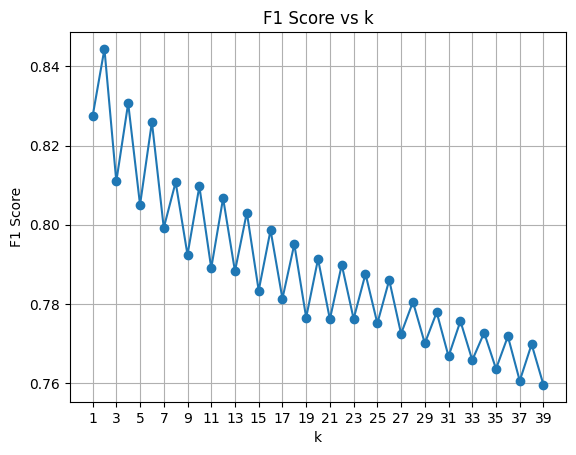

Best k: 2 at 0.8444112484890159
F1 Score: 0.8444112484890159


In [145]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics  import f1_score

macro_f1_scores = []
for k in range(1, 40):
    classifierObj = KNeighborsClassifier(n_neighbors=k)
    classifierObj.fit(X_train_pca, y_train_smote)
    y_pred = classifierObj.predict(X_test_pca)
    f1 = f1_score(y_test_smote, y_pred, average='macro')
    macro_f1_scores.append(f1)

plt.plot(range(1, 40, 1), macro_f1_scores, marker='o')
plt.xlabel('k')
plt.ylabel('F1 Score')
plt.title('F1 Score vs k')
plt.xticks(range(1, 40, 2))
plt.grid(True)
plt.show()

best_k_index = np.argmax(macro_f1_scores) + 1
print(f"Best k: {best_k_index} at {macro_f1_scores[best_k_index-1]}")

classifierObj = KNeighborsClassifier(n_neighbors=2)
classifierObj.fit(X_train_pca, y_train_smote)
y_pred = classifierObj.predict(X_test_pca)
f1 = f1_score(y_test_smote, y_pred, average='macro')
print(f"F1 Score: {f1}")


In [146]:
from sklearn.ensemble import VotingClassifier

classifiers = [
    ('RandomForestClassifier', RandomForestClassifier()),
    ('DecisionTreeClassifier', DecisionTreeClassifier()),
    ('LogisticRegression', LogisticRegression()),
    ('KNN', KNeighborsClassifier(n_neighbors=10)),
    ('SVC', SVC(kernel='rbf')),
    ('GaussianNB', GaussianNB()),
    ('AdaBoostClassifier', AdaBoostClassifier()),
    ('GradientBoostingClassifier', GradientBoostingClassifier())
]

votingClassifier = VotingClassifier(estimators=classifiers, voting='hard')
modelclassificationreport(votingClassifier, "VotingClassifier")

Classification Report for Classifier: VotingClassifier(estimators=[('RandomForestClassifier',
                              RandomForestClassifier()),
                             ('DecisionTreeClassifier',
                              DecisionTreeClassifier()),
                             ('LogisticRegression', LogisticRegression()),
                             ('KNN', KNeighborsClassifier(n_neighbors=10)),
                             ('SVC', SVC()), ('GaussianNB', GaussianNB()),
                             ('AdaBoostClassifier', AdaBoostClassifier()),
                             ('GradientBoostingClassifier',
                              GradientBoostingClassifier())]), className: VotingClassifier
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      4500
           1       0.86      0.83      0.85      4499

    accuracy                           0.85      8999
   macro avg       0.85      0.85      0.85      8999
weighted avg